# CNN Classification

In [2]:
import numpy as np
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import zoom

from PIL import Image
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout
from keras.layers import MaxPooling2D,Flatten
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras.optimizers import Adam
from keras.models import load_model

from sklearn.metrics import confusion_matrix

import h5py   
import itertools

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading data

In [3]:
cd = os.getcwd()
cd

'/home/vjf2107/final_project_data_science'

In [4]:
Xtrain = pd.read_csv('/home/vjf2107/final_project_data_science/Xtrain_data.csv')
ytrain = pd.read_csv('/home/vjf2107/final_project_data_science/ytrain.csv')
Xtest = pd.read_csv('/home/vjf2107/final_project_data_science/Xtest_data.csv')
ytest = pd.read_csv('/home/vjf2107/final_project_data_science/ytest.csv')

## Preparing the training matrix

In [5]:
path = Xtrain.loc[0][2].split("\\")
path[-2]

'PIT'

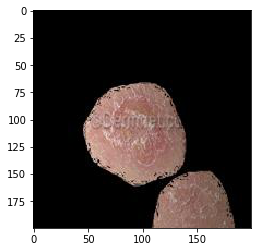

In [6]:
im = mpimg.imread('/home/vjf2107/final_project_data_science/'+path[-3]+'/'+path[-2]+'/'+path[-1])
plt.figure
plt.imshow(im)

In [7]:
Xtrain_feat = []
Xtest_feat = []

for filename in Xtrain.values:
    temp_path = filename[2].split("\\")
    im_temp = mpimg.imread('/home/vjf2107/final_project_data_science/'+temp_path[-3]+'/'+temp_path[-2]+'/'+temp_path[-1])
    Xtrain_feat.append(im_temp)
    
for filename in Xtest.values:
    temp_path = filename[2].split("\\")
    im_temp = mpimg.imread('/home/vjf2107/final_project_data_science/'+temp_path[-3]+'/'+temp_path[-2]+'/'+temp_path[-1])
    Xtest_feat.append(im_temp)


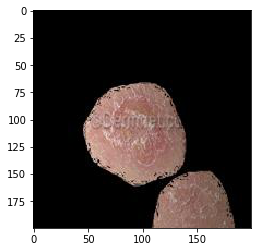

In [8]:
np.shape(Xtrain_feat)
plt.figure
plt.imshow(Xtrain_feat[0][:][:][:])

In [9]:
type(Xtest_feat)

list

## Data augmentation

In [8]:
def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [9]:
ytrain_aug = []

for i in range(0,Xtrain.shape[0]):
    im_temp = Xtrain_feat[i][:][:][:]
    
    a = np.rot90(im_temp,1)
    b = np.flipud(np.rot90(im_temp,2))
    c = np.rot90(clipped_zoom(im_temp,1.5),3)
    
    Xtrain_feat.extend(np.expand_dims(a,axis=0))
    Xtrain_feat.extend(np.expand_dims(b,axis=0))
    Xtrain_feat.extend(np.expand_dims(c,axis=0))
    
    ytrain_aug.append(ytrain.loc[i][1])
    ytrain_aug.append(ytrain.loc[i][1])
    ytrain_aug.append(ytrain.loc[i][1])
    
    if (i % 100 == 0):
        print(i/Xtrain.shape[0])
        
ytrain = np.append(np.array(ytrain)[:,1].astype(int) , np.array(ytrain_aug))

/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777778
0.8888888888888888


## One hot label encoder

In [10]:
#Number of classes 
n = 7

#One hot label encoder
enc = LabelEncoder()
enc.fit(np.arange(1,n+1))
enc.transform(np.arange(1,n+1))
train_labels1 = enc.transform(ytrain)
train_labels = np_utils.to_categorical(train_labels1)

## Building the model

### Simple CNN: LeNet

In [11]:
model = Sequential()
                 
# Add a 2D convolution layer, the kernel size is 5*5, activation function
# is relu and the output feature is 32
model.add(Conv2D(32,kernel_size=(5,5),strides=(1,1),padding='same',
                 activation='relu',input_shape=(200,200,3)))
# Max pooling operation, pool size is 2*2, strides is 2*2
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same'))
#Add a 2D convolution layer, the kernel size is 5*5, activation function
#is relu and the output feature is 64
model.add(Conv2D(64,kernel_size=(5,5),strides=(1,1),padding='same',
                 activation='relu'))
# Max pooling operation, pool size is 2*2, strides is 2*2
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same'))
# Flatten the input
model.add(Flatten())
# Add a fully connected layer whose output dims is 1024, and activation
# function is relu
model.add(Dense(32,activation='relu'))
# Apply dropout, 0.5 of the input units to drop
model.add(Dropout(rate=0.5))
# Add a fully connected layer whose output dims is 10, and activation
# function is softmax
model.add(Dense(n,activation='softmax'))
# Using adam to optimize and learning rate is 1e-4
adam = keras.optimizers.Adam(lr = 1e-4)

# Configure the learning process, loss function is 
# categorical_crossentropy
model.compile(loss='categorical_crossentropy',optimizer=adam,
             metrics=['accuracy'])

batch_size = 32
epoch = 10

# the filepath to save best model
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor='val_acc',mode='max',
                            save_best_only=True,verbose=1)

tensorboard = TensorBoard(log_dir="./logs3",
                          write_images=True,batch_size=batch_size)
callback_list = [checkpoint,tensorboard]

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                5120032   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

### TextureNet

In [12]:
model2 = Sequential()

model2.add(Conv2D(32,kernel_size=(3,3), activation='relu',input_shape=(200,200,3)))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(32,kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
           
model2.add(Conv2D(32,kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())

model2.add(Dense(64,activation='relu'))
model2.add(Dropout(rate=0.5))
           
model2.add(Dense(n,activation='sigmoid'))

model2.compile(loss='categorical_crossentropy',optimizer=Adam(lr=1e-4),
             metrics=['accuracy'])

epoch = 30
batch_size = 32

# the filepath to save best model
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor='val_acc',mode='max',
                            save_best_only=True,verbose=1)

tensorboard = TensorBoard(log_dir="./logs3",
                          write_images=True,batch_size=batch_size)
callback_list = [checkpoint,tensorboard]

print(model2.summary())
           
           

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16928)             0         
__________

### Small ConvNet

In [20]:
model3 = Sequential()

model3.add(Conv2D(32,kernel_size=(3,3), activation='relu', padding='same',input_shape=(200,200,3)))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(48,kernel_size=(3,3), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
           
# model3.add(Conv2D(40,kernel_size=(3,3), padding='same', activation='relu'))
# model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())

model3.add(Dense(64,activation='relu'))
model3.add(Dropout(rate=0.6))

# model3.add(Dense(128,activation='relu'))
# model3.add(Dropout(rate=0.6))
           
model3.add(Dense(n,activation='softmax'))

model3.compile(loss='categorical_crossentropy',optimizer=Adam(lr=1e-3),
             metrics=['accuracy'])

epoch = 30
batch_size = 32

# the filepath to save best model
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor='val_acc',mode='max',
                            save_best_only=True,verbose=1)

tensorboard = TensorBoard(log_dir="./logs3",
                          write_images=True,batch_size=batch_size)
callback_list = [checkpoint,tensorboard]

print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 100, 100, 48)      13872     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 50, 50, 48)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 120000)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                7680064   
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
__________

In [13]:
# Train the model
H = model2.fit(np.array(Xtrain_feat),train_labels,
             batch_size=batch_size,epochs = epoch,verbose=1,
             callbacks=callback_list,validation_split=0.20)

Train on 2880 samples, validate on 720 samples
Epoch 1/30
2880/2880 [==============================] - 140s 49ms/step - loss: 3.0470 - acc: 0.1944 - val_loss: 2.0270 - val_acc: 0.1903

Epoch 00001: val_acc improved from -inf to 0.19028, saving model to weights.hdf5
Epoch 2/30
2880/2880 [==============================] - 141s 49ms/step - loss: 2.2680 - acc: 0.2135 - val_loss: 1.9193 - val_acc: 0.2014

Epoch 00002: val_acc improved from 0.19028 to 0.20139, saving model to weights.hdf5
Epoch 3/30
2880/2880 [==============================] - 141s 49ms/step - loss: 2.0555 - acc: 0.2181 - val_loss: 1.8862 - val_acc: 0.2431

Epoch 00003: val_acc improved from 0.20139 to 0.24306, saving model to weights.hdf5
Epoch 4/30
2880/2880 [==============================] - 141s 49ms/step - loss: 1.9541 - acc: 0.2330 - val_loss: 1.8207 - val_acc: 0.3083

Epoch 00004: val_acc improved from 0.24306 to 0.30833, saving model to weights.hdf5
Epoch 5/30
2880/2880 [==============================] - 141s 49ms/st

In [12]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

In [15]:
get_model_memory_usage(128, model2)

1.501

## Results 

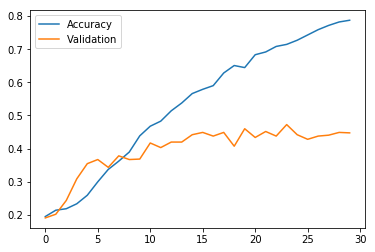

In [14]:
plt.plot(H.history['acc'],label='Accuracy')
plt.plot(H.history['val_acc'],label='Validation')
plt.legend()

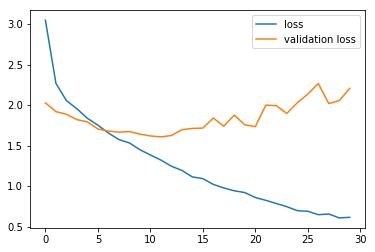

In [15]:
plt.plot(H.history['loss'],label='loss')
plt.plot(H.history['val_loss'],label='validation loss')
plt.legend()

In [26]:
y_pred = model2.predict_classes(np.array(Xtest_feat))
y_pred[0:1000]

array([4, 0, 4, 6, 2, 2, 0, 2, 6, 6, 0, 4, 5, 0, 6, 2, 0, 0, 0, 2, 2, 0,
       2, 2, 5, 1, 2, 5, 6, 2, 4, 4, 2, 2, 4, 0, 2, 0, 4, 1, 1, 0, 2, 0,
       1, 6, 4, 5, 0, 2, 6, 2, 4, 0, 6, 2, 2, 2, 4, 2, 6, 4, 0, 0, 4, 4,
       4, 3, 1, 2, 2, 0, 1, 4, 4, 3, 0, 0, 6, 4, 1, 1, 0, 0, 0, 4, 4, 2,
       0, 4, 2, 4, 2, 5, 6, 0, 4, 4, 2, 0, 4, 5, 1, 2, 2, 0, 6, 2, 4, 2,
       2, 5, 2, 0, 0, 5, 2, 2, 6, 2, 2, 2, 1, 5, 4, 2, 2, 2, 5, 2, 4, 2,
       4, 4, 2, 6, 4, 1, 2, 6, 4, 0, 0, 4, 2, 4, 2, 4, 6, 0, 4, 2, 2, 0,
       4, 0, 0, 2, 0, 2, 2, 3, 2, 4, 2, 2, 2, 4, 4, 2, 0, 6, 2, 2, 6, 1,
       4, 0, 2, 4, 4, 4, 6, 2, 0, 2, 2, 2, 0, 2, 2, 4, 4, 6, 4, 1, 2, 0,
       4, 2, 0, 0, 0, 6, 4, 0, 2, 2, 2, 2, 6, 5, 0, 6, 2, 2, 4, 2, 1, 2,
       0, 2, 2, 4, 1, 2])

Confusion matrix, without normalization
[[18  3  2  0 10  2  6]
 [10  6  3  0  2  1  1]
 [ 3  1 50  1  3  2  1]
 [ 2  0  8  2  2  1  0]
 [ 4  2  5  0 24  2  6]
 [ 3  1  7  0  4  2  3]
 [ 6  2  3  0  5  1  6]]
Normalized confusion matrix
[[0.44 0.07 0.05 0.   0.24 0.05 0.15]
 [0.43 0.26 0.13 0.   0.09 0.04 0.04]
 [0.05 0.02 0.82 0.02 0.05 0.03 0.02]
 [0.13 0.   0.53 0.13 0.13 0.07 0.  ]
 [0.09 0.05 0.12 0.   0.56 0.05 0.14]
 [0.15 0.05 0.35 0.   0.2  0.1  0.15]
 [0.26 0.09 0.13 0.   0.22 0.04 0.26]]


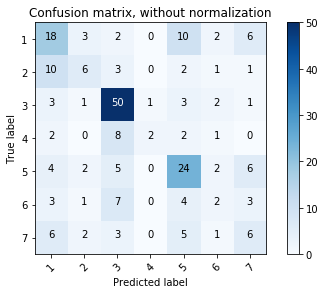

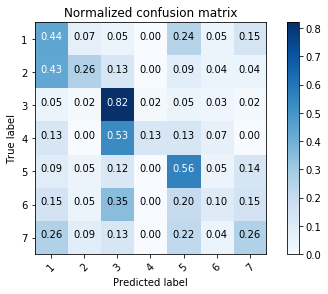

In [27]:
# y_pred = model2.predict_classes(np.array(Xtrain_feat))
y_pred = y_pred+1

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# y_pred = model2.predict_classes(np.array(Xtrain_feat))
class_names = np.array(['1','2','3','4','5','6','7'])
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(ytest, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()